# Multiple regression

##### Libraries

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Goals of this lecture
 
- Regression with **multiple predictors**: why?
- Implementing and interpreting models with multiple predictors.
- Techniques for identifying (or *selecting*) important predictors.
- Models with **interactions**.

## Why multiple regression?

> **Multiple regression** means building a regression model (e.g., linear regression) with *more than one predictor*.

Why might we want to do this?

### The curious case of ice cream sales and shark attacks

Many [datasets](https://uclspp.github.io/PUBLG100/) find a *correlation* between the number of ice cream sales in a given month and the number of shark attacks in that month.

In [3]:
df_sharks = pd.read_csv("data/models/shark_attacks.csv")
df_sharks.head(1)

,Year,Month,SharkAttacks,Temperature,IceCreamSales
0,2008,1,25,11.9,76


#### Comparing `IceCreamSales` to `SharkAttacks`

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


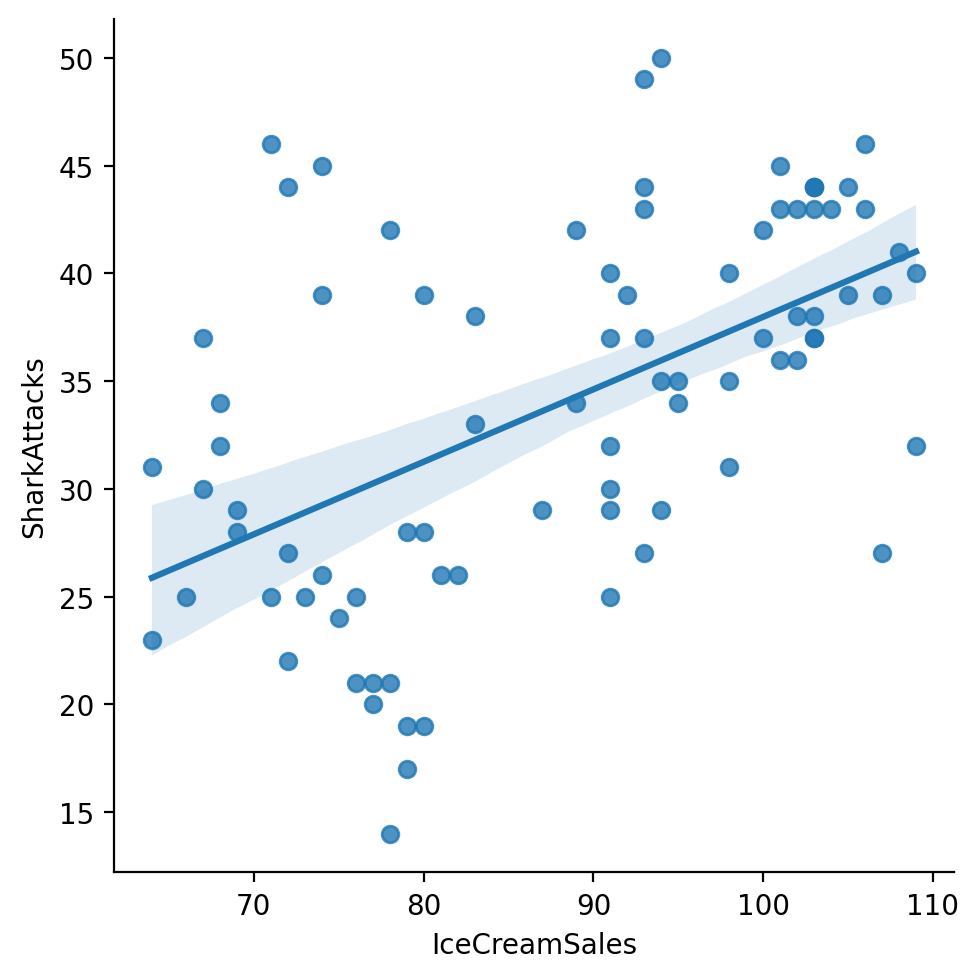

In [4]:
sns.lmplot(data = df_sharks, x = "IceCreamSales", y = "SharkAttacks")

#### Testing with univariate linear regression

In a univariate linear model, `IceCreamSales` is significantly predictive of `SharkAttacks` ($p < .001$).

In [5]:
mod_ic = smf.ols(data = df_sharks, formula = "SharkAttacks ~ IceCreamSales").fit()
mod_ic.params

Intercept        4.352305
IceCreamSales    0.336269
dtype: float64

In [6]:
mod_ic.pvalues

Intercept        4.084159e-01
IceCreamSales    1.647822e-07
dtype: float64

#### Check-in

What other variable might be *correlated* with both `SharkAttacks` and `IceCreamSales`?

#### `Temperature` and `SharkAttacks` are also correlated

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


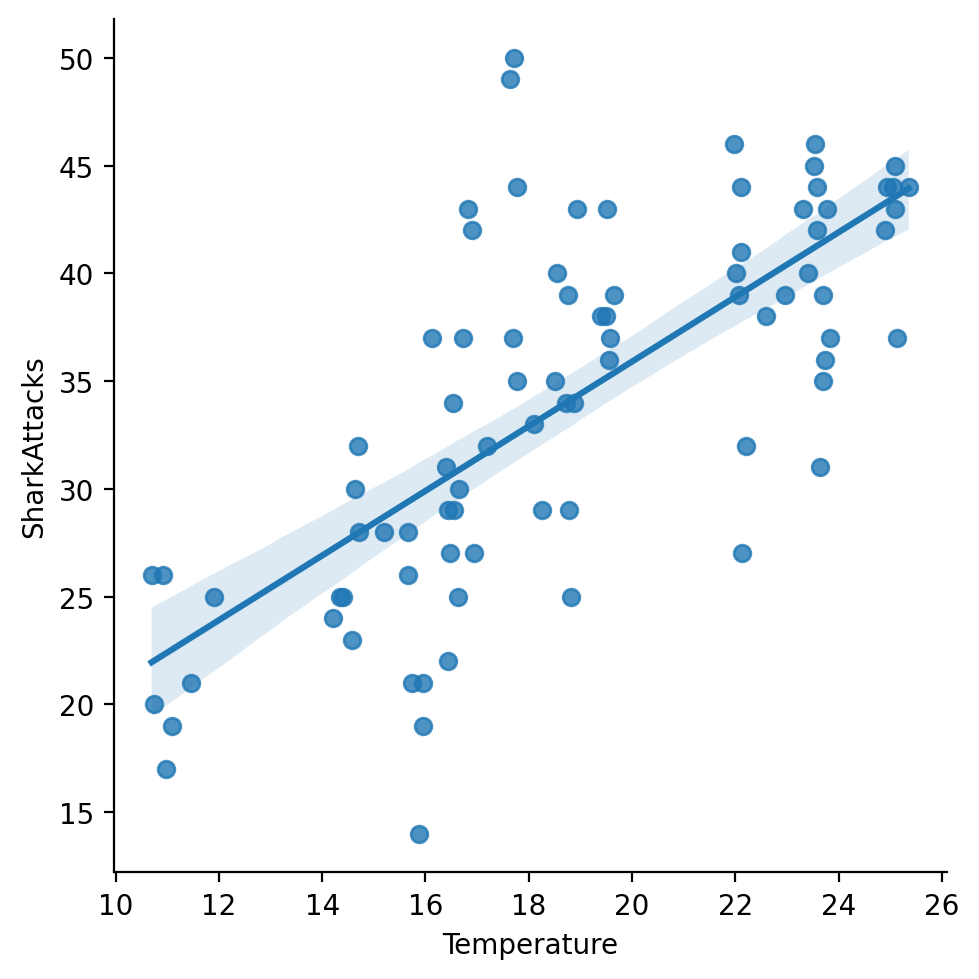

In [7]:
sns.lmplot(data = df_sharks, x = "Temperature", y = "SharkAttacks")

#### So are `Temperature` and `IceCreamSales`

(Though there also appears to be distinct **clustering**, possibly by `Month`.)

<Axes: xlabel='Temperature', ylabel='IceCreamSales'>

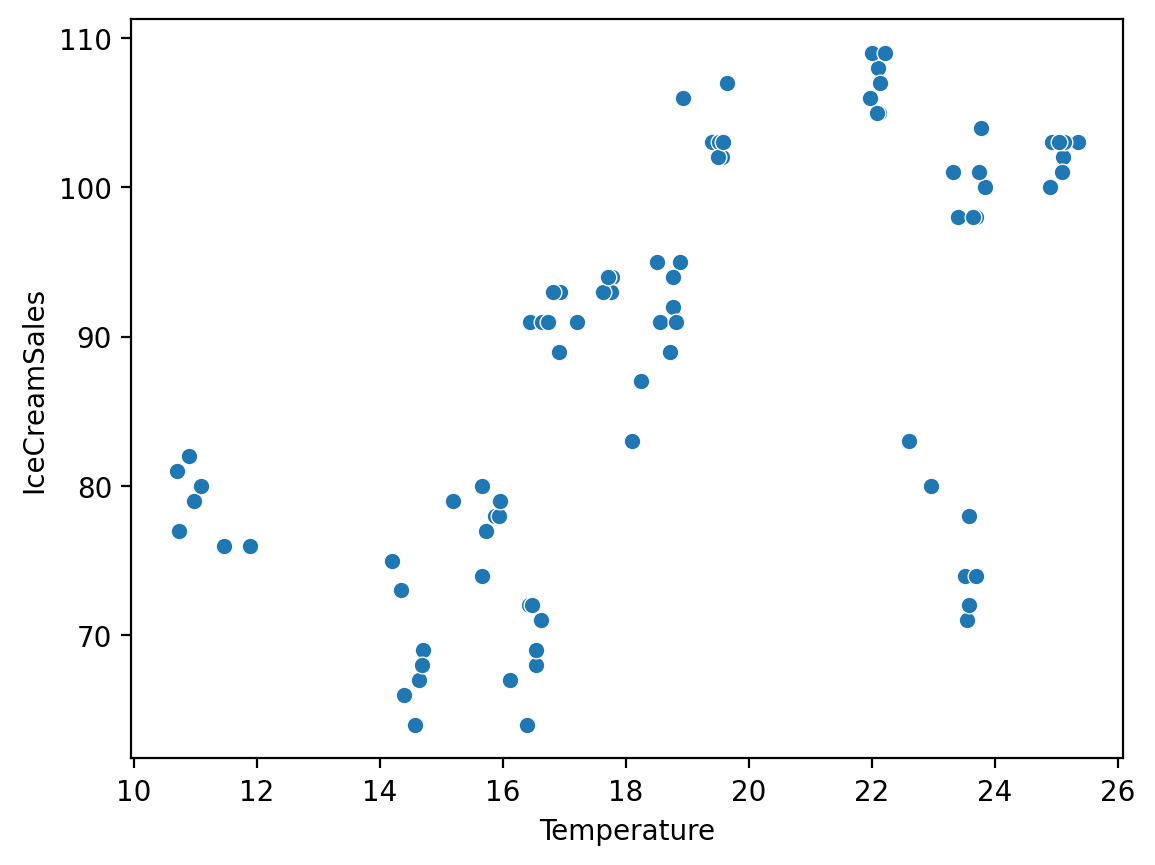

In [8]:
sns.scatterplot(data = df_sharks, x = "Temperature", y = "IceCreamSales")

#### Adjusting for `Temperature`

It's plausible to imagine that higher **temperatures** have a **causal impact** on:

- People going to the beach (raising the likelihood of `SharkAttacks`).  
- People buying ice cream (increasing `IceCreamSales`).

Thus, we can **adjust** for the impact of `Temperature` in our regression model.

In [9]:
mod_both = smf.ols(data = df_sharks, formula = "SharkAttacks ~ IceCreamSales + Temperature").fit()
mod_both.params

Intercept        0.565099
IceCreamSales    0.104591
Temperature      1.292756
dtype: float64

In [10]:
mod_both.bse

Intercept        4.305143
IceCreamSales    0.059566
Temperature      0.198021
dtype: float64

### Reason 1: Adjusting for confounds

> One reason to add *multiple variables* to a linear model is to **adjust for confounding variables**.

This allows you to identify the **independent effect** of two or more $X$ variables on $Y$.

### Reason 2: Better models.

> Typically, adding more parameters ($p$) **improves model fit**.

If your goal is to *reduce errors*, then more predictors will usually do this (reducing $MSE$).

## Implementing and interpreting multiple regression models

### Predicting California housing prices

- Presumably, many different factors determine the price of house.
- Rather than considering each in isolation, we can consider them together.

**What factors would you like to include?**

In [11]:
df_housing = pd.read_csv("data/housing.csv")
df_housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


#### Using `housing_median_age` and `median_income`

To start, let's use both the *median age of houses* as well as the *median income* in a neighborhood.

In [12]:
mod_housing = smf.ols(data = df_housing,
                     formula = "median_house_value ~ housing_median_age + median_income").fit()

### Interpreting our parameters

With multiple regression, each coefficient $\beta_j$ reflects:

- **Amount of change** in $Y$ associated with changes in $X_j$... 
- ...holding all other variables **constant** (i.e., *ceteris paribus*).  


In [13]:
### Interpreting parameters
mod_housing.params

Intercept            -10189.032759
housing_median_age     1744.134446
median_income         43169.190754
dtype: float64

#### Check-in

How would you write this as a *linear equation*?

#### Writing our model as a *linear equation*

With two predictors, our model looks like this:

$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2$

So in this case, it'd look like:

$Y = -10189 + 1744 * X_{age} + 43169 * X_{income}$

#### Interpreting the `Intercept`

With this equation, the `Intercept` is the predicted price of houses that are:

- `age = 0`.  
- `income = 0`.

$Y = -10189 + 1744 * X_{age} + 43169 * X_{income}$

Which ends up being a **negative value** (weirdly).



#### Interpreting $\beta_{age}$

$\beta_{age}$ refers to the **predicted increase** in a house's price, for each 1-unit increase in `age`...while holding `income` constant!

$Y = -10189 + 1744 * X_{age} + 43169 * X_{income}$


#### Interpreting $\beta_{income}$

$\beta_{income}$ refers to the **predicted increase** in a house's price, for each 1-unit increase in `income`...while holding `age` constant!

$Y = -10189 + 1744 * X_{age} + 43169 * X_{income}$


### Putting it all together

- Any *given observation*, of course, has both an `age` and an `income`.
- Thus, the model reflects $\hat{Y}$ for a *particular* `age` and a particular `income`.

In [14]:
## predicted price for age = 10 and income = 10
-10189 + 1744 * 10 + 43169 * 10

438941

In [15]:
## predicted price for age = 20 and income = 10
-10189 + 1744 * 20 + 43169 * 10

456381

In [16]:
## predicted price for age = 10 and income = 20
-10189 + 1744 * 20 + 43169 * 20

888071

### Evaluating our model

Typically, models with more parameters ($p$) have better **fit**, e.g., higher $R^2$ and lower $S_{Y|X}$.

In [17]:
## rsquared
mod_housing.rsquared

0.5091195899765238

In [18]:
## standard error of the estimate
np.sqrt(mod_housing.scale)

80853.38432785697

#### Check-in

Build two *univariate* regression models, predicting `median_house_value` from each of the two predictors considered below (i.e., a model for `age` and a model for `income`). What is the $R^2$ of each of these models?

In [19]:
### Your code here

#### Solution

In [20]:
mod_age = smf.ols(data = df_housing,
                     formula = "median_house_value ~ housing_median_age").fit()
mod_income = smf.ols(data = df_housing,
                     formula = "median_house_value ~ median_income").fit()

In [21]:
print(mod_age.rsquared)
print(mod_income.rsquared)

0.011156305266713185
0.4734474918071987


#### Visualizing differences in $R^2$

**Building intuition**: Based on this visualization, which variable of the two do you think seems more important? (Coming up later this lecture!)

<Axes: xlabel='R^2', ylabel='Predictors'>

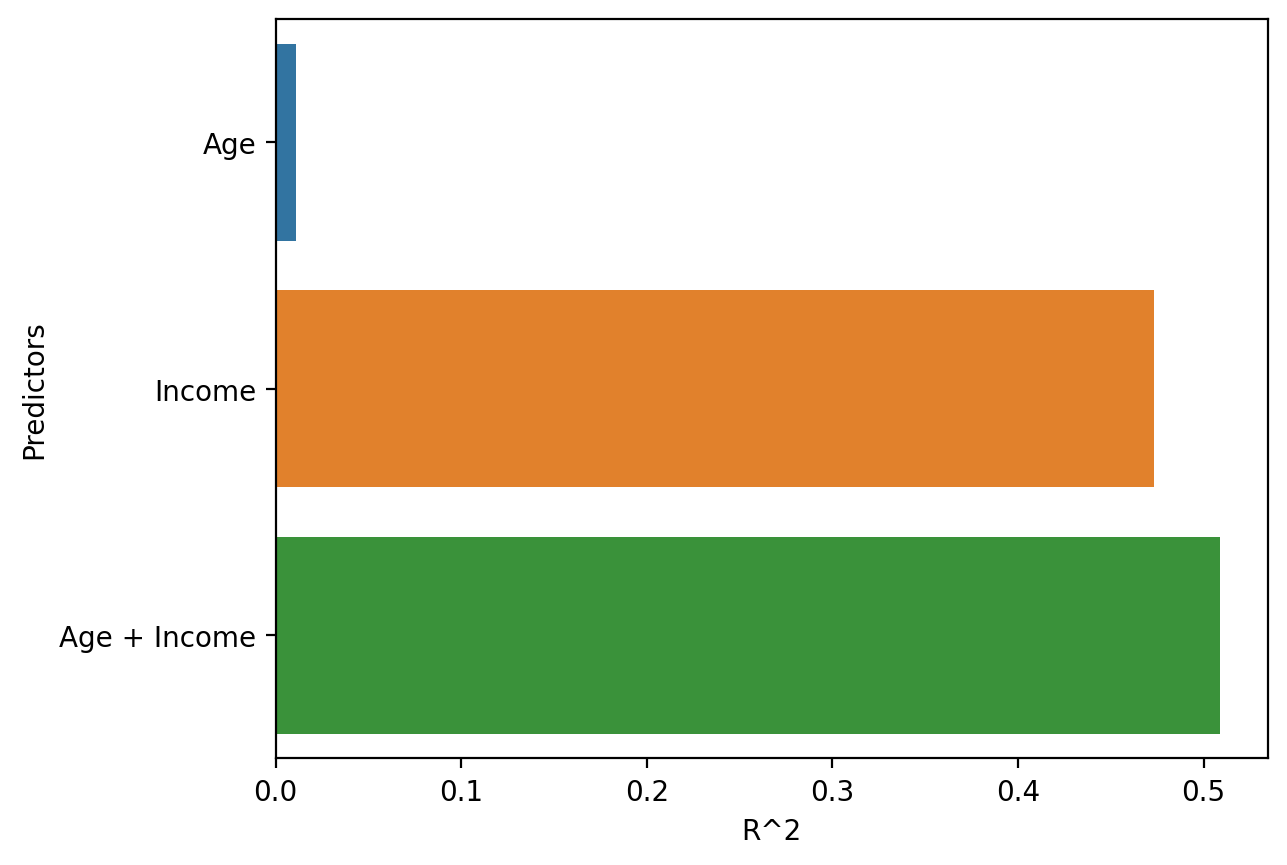

In [22]:
df_r2 = pd.DataFrame({'R^2': [mod_age.rsquared, mod_income.rsquared, mod_housing.rsquared],
                     'Predictors': ['Age', 'Income', 'Age + Income']})
sns.barplot(data = df_r2, y = "Predictors", x = "R^2")

## Models with "interactions"

### Removing the additive assumption

> An **"interaction effect"** occurs when the effect of one variable ($X_1$) depends on the value of another variable ($X_2$).

- So far, we've assumed that different predictors have **independent** and **additive** effects.  
   - I.e., **main effects** of a variable $X_1$ and $X_2$.
- An "interaction" (or "synergistic") effect removes that assumption.
   - In model, allows for **interaction** $X_1 X_2$.

### Examples of common interactions

Interaction effects are often easiest to observe and understand between two **categorical variables**.

- `Treatment x Gender`: `Treatment` works in `males` but not `females`.  
- `Brain Region x Task`: **double dissociation** between `Region` of damage and which `Task` impairment is observed on.
- `Food x Condiment`: enjoyment of a `Condiment` depends on kind of food.
   - E.g., `Ketchup` is good on `Hot Dog`, while `Chocolate Sauce` is good on `Ice Cream`.

#### Double dissociations

> In neuroscience, a [**double dissociation**](https://dictionary.apa.org/double-dissociation) is a demonstration that two brain areas (or biological systems) have *independent* or *localizable* effects.

<Axes: xlabel='Region', ylabel='Performance'>

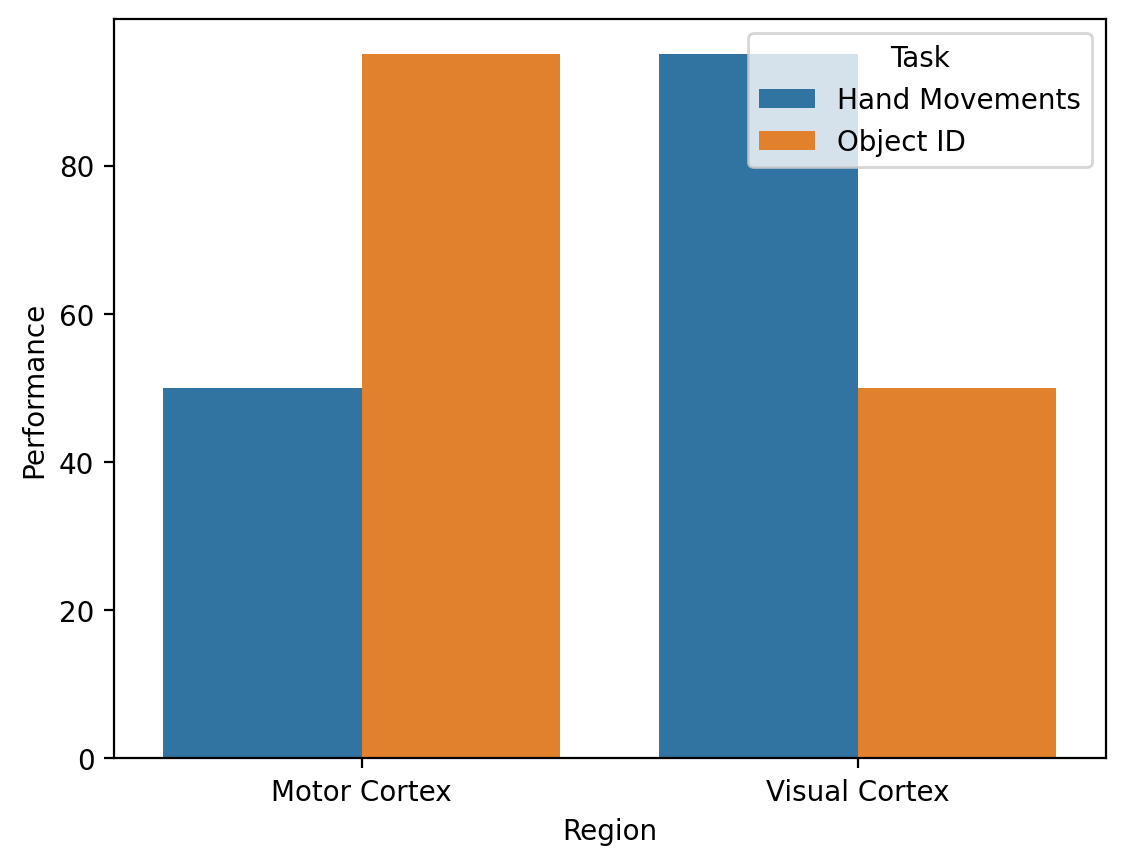

In [23]:
df_damage = pd.DataFrame({'Region': ['Motor Cortex', 'Motor Cortex', 'Visual Cortex', 'Visual Cortex'],
                         'Task': ['Hand Movements', 'Object ID', 'Hand Movements', 'Object ID'],
                         'Performance': [50, 95, 95, 50]})
sns.barplot(data = df_damage, x = "Region", 
            y = "Performance", hue = "Task")

### Discovering interactions with data visualization

As a first illustration of an interaction between **categorical** and **continuous** variable, let's consider the `mtcars` dataset.

In [24]:
df_cars = pd.read_csv("data/models/mtcars.csv")
df_cars.head(3)

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1


#### First steps: main effects (pt. 1)

This dataset contains at least two *main effects*: a correlation between `wt` and `mpg`, and a correlation between `am` (automatic = 0, manual = 1) and `mpg`.

<Axes: xlabel='wt', ylabel='mpg'>

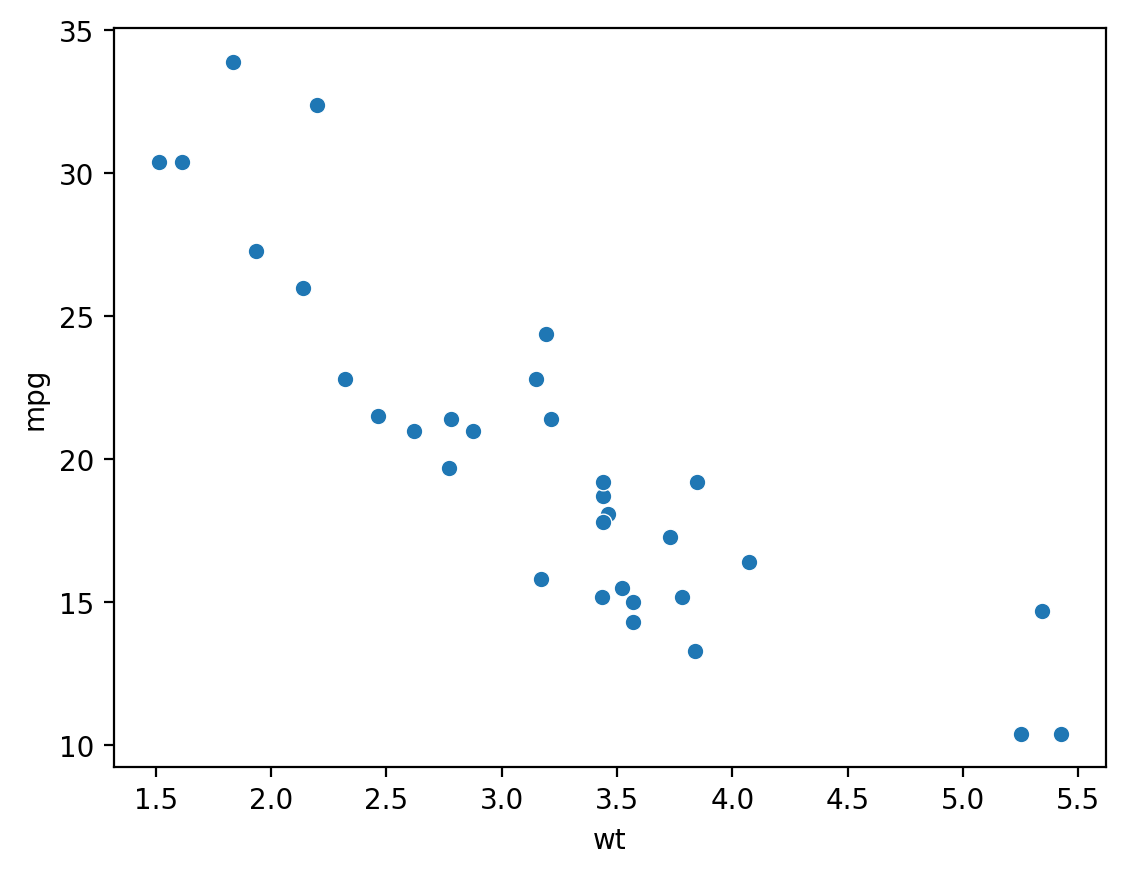

In [25]:
sns.scatterplot(data = df_cars, x = "wt", y = "mpg")

#### First steps: main effects (pt. 2)

This dataset contains at least two *main effects*: a correlation between `wt` and `mpg`, and a correlation between `am` (automatic = 0, manual = 1) and `mpg`.

<Axes: xlabel='am', ylabel='mpg'>

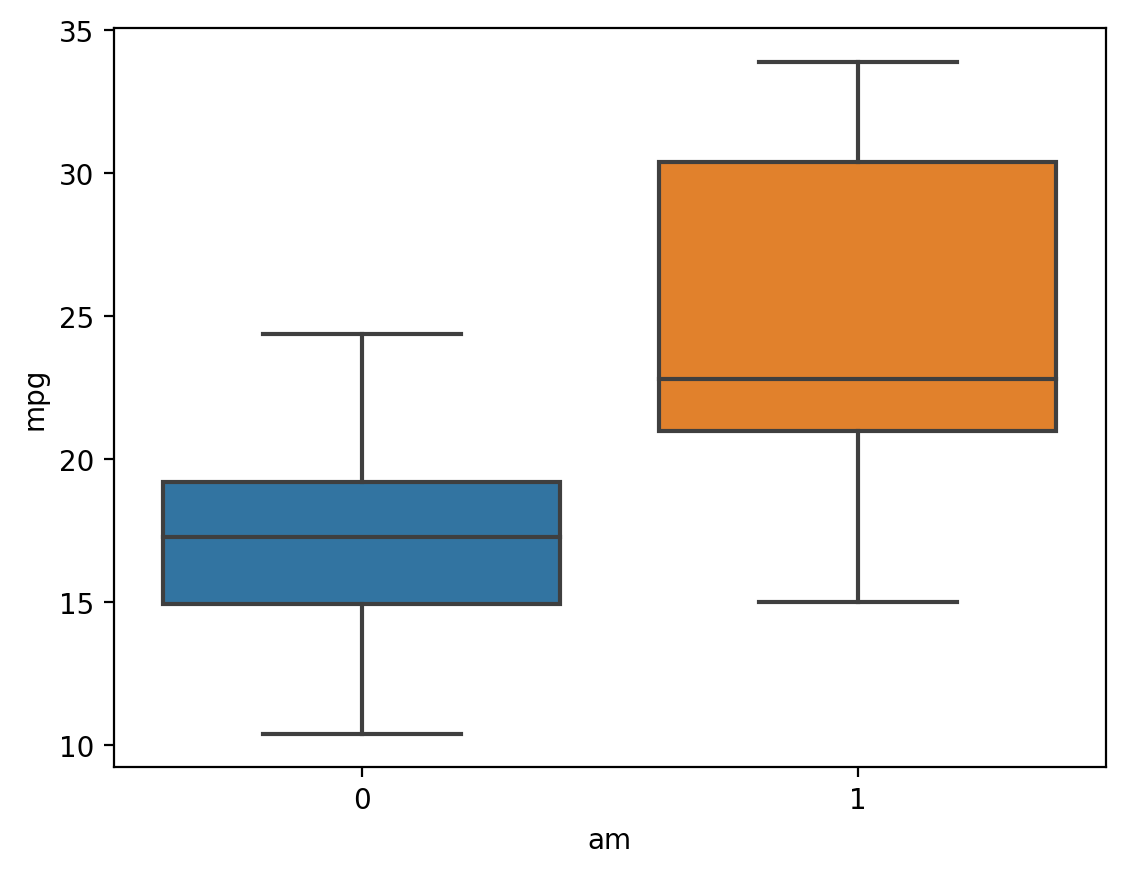

In [26]:
sns.boxplot(data = df_cars, x = "am", y = "mpg")

#### Check-in

How could we use **data visualization** to ask whether `wt` and `am` have an **interaction effect** on `mpg`?

In [27]:
### Your code here

#### Solution

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


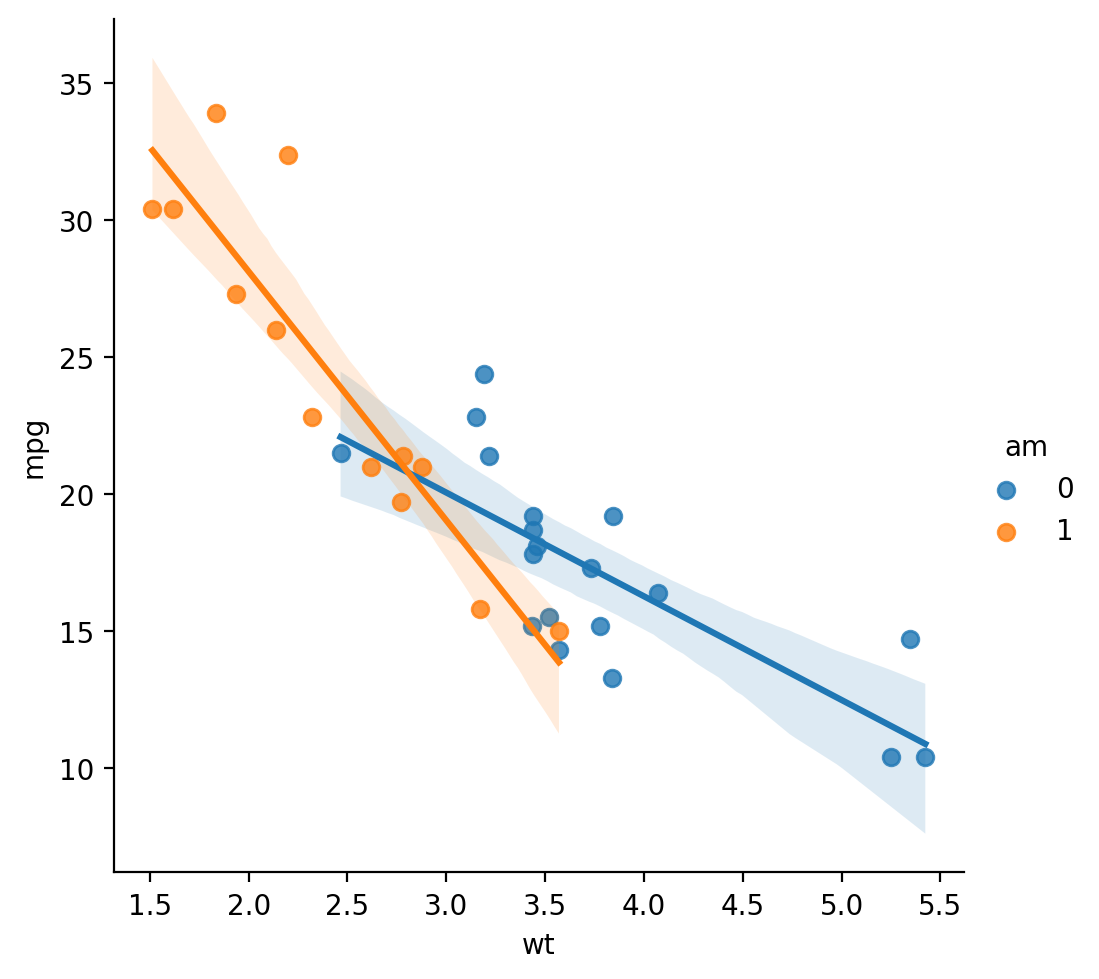

In [28]:
sns.lmplot(data = df_cars, x = "wt", y = "mpg", hue = "am")

### Testing for interactions with `statsmodels`

In `statsmodels`, an **interaction term** can be added between two variables using the `*` syntax (rather than `+`):

```python
formula = "Y ~ X1 * X2`
```

#### Check-in

Build a linear model predicting `mpg`, with an interaction between `am` and `wt`. What can we conclude about the result?

In [29]:
### Your code here

#### Model output

The $p$-value for `wt:am` is significant, suggesting a significant interaction.

In [30]:
mod_interaction = smf.ols(data = df_cars, formula = "mpg ~ wt * am").fit()
mod_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     46.57
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           5.21e-11
Time:                        10:40:17   Log-Likelihood:                -73.738
No. Observations:                  32   AIC:                             155.5
Df Residuals:                      28   BIC:                             161.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.4161      3.020     10.402      0.000      25.230      37.602
wt            -3.7859      0.786     -4.819      0.000      -5.395      -2.177
am            14.8784      4.264      3.489      0.002       6.144      23.613
wt:am         -5.2984      1.445     -3.667      0.001      -8.258      -2.339
==============================================================================
Omnibus:                        3.839   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.088
Skew:                           0.761   Prob(JB):                        0.213
Kurtosis:                       2.963   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpreting parameters

- `wt`: negative slope, i.e., heavier cars have lower `mpg`.  
- `am`: positive slope, i.e., manual cars have higher `mpg`.  
- `wt:am`: negative slope, i.e., a **stronger (steeper) effect** of `wt` on `mpg` for *manual* than *automatic* cars.

$\hat{Y} = 31.41 - 3.79*X_{weight} + 14.88*X_{am} - 5.3 * X_{weight} * X_{am}$

In [31]:
mod_interaction.params

Intercept    31.416055
wt           -3.785908
am           14.878423
wt:am        -5.298360
dtype: float64

## Which predictors *matter*?

### The problem of too many parameters

- Adding more parameters will always at least *slightly* improve the model.  
- But too many parameters can also lead to **overfitting** (coming up!). 
- It can also make the model very hard to **interpret**.
- Thus, it's important to identify which parameters are most important.

There are **many approaches** to identifying which parameters matter the most.

### Building intuition: Comparing $R^2$

A visual comparison of $R^2$ for models with different predictors helps build intuition. 

What is the **relative improvement** in the "full" model (`Age + Income`) compared to each of the "simpler" models (`Age` vs. `Income`)?  

<Axes: xlabel='R^2', ylabel='Predictors'>

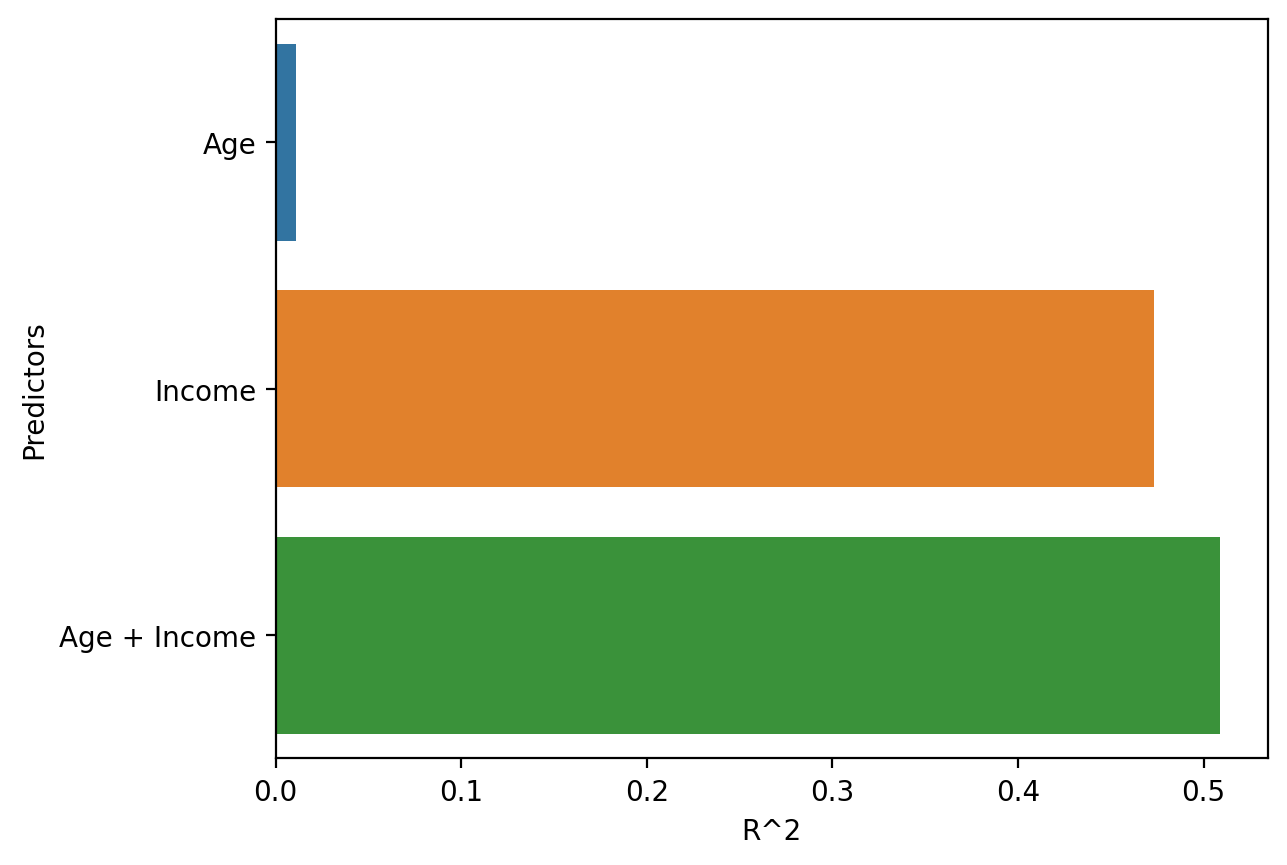

In [32]:
sns.barplot(data = df_r2, y = "Predictors", x = "R^2")

### Introducing subset selection

> **Subset selection** refers to identifying the subset of $p$ predictors that are most related to the response, i.e., result in the "best" model.

Basic logic:

- Fit a bunch of different models.  
- Identify which model is best using a measure of model fit.
   - Ideally, this measure should **correct** for the problem of over-fitting. 



#### Best subset selection

> In **Best subset selection**, you fit a separate model for each combination of $p$ predictors.

- For each parameter, fit a separate model with that predictor. 
- For each *pair* of predictors, fit a separate model with that pair. 
- ... And so on. 

Why might this be challenging to do in practice?

##### An ideal but intractable solution

> As $p$ increases, the number of possible models *also* increases. There are approximately $2^p$ models considering $p$ predictors.

Text(0, 0.5, 'Number of possible models')

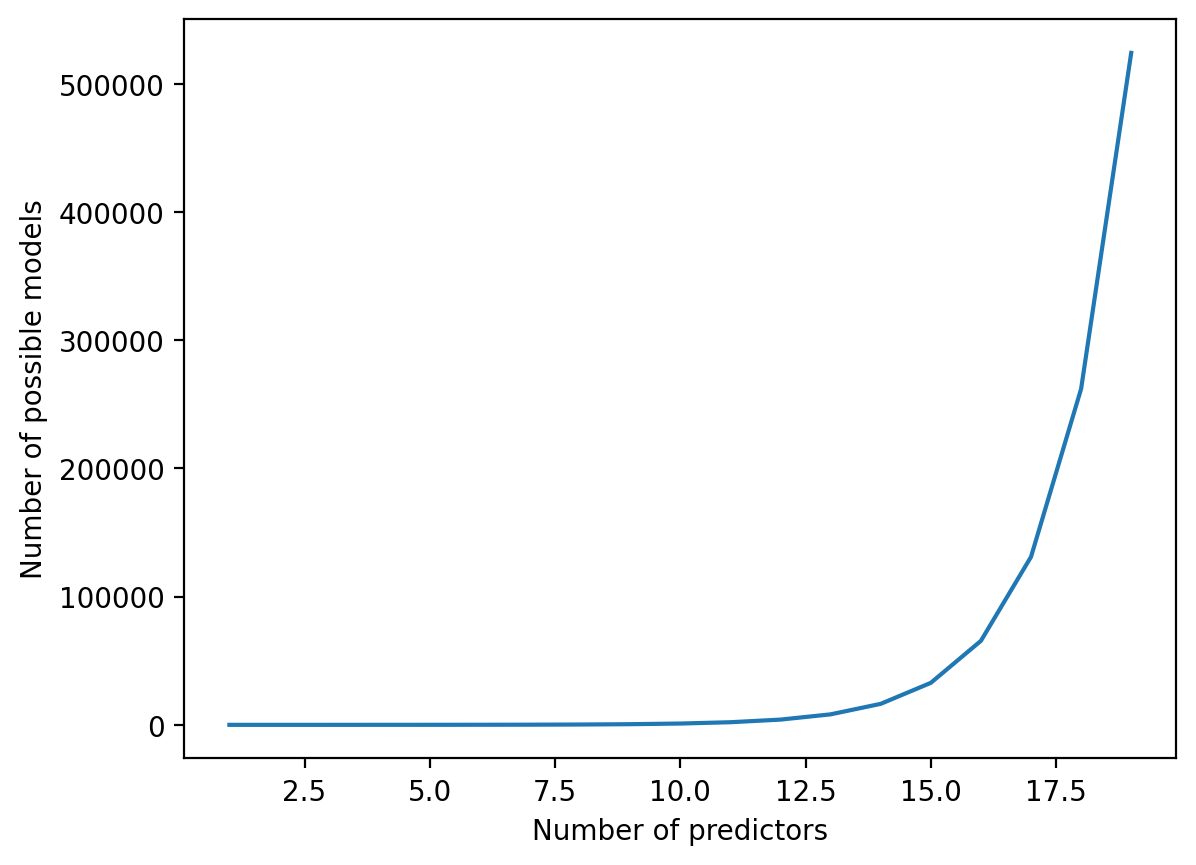

In [33]:
p = np.arange(1, 20)
m = 2 ** p
plt.plot(p, m)
plt.xlabel("Number of predictors")
plt.ylabel("Number of possible models")

#### Forward selection

> In **forward stepwise selection**, we add predictors to the model one at the time; at each time-step, we add the predictor that *best improves the model*.

1. Start with the "null" model (no predictors), i.e., $M_{k=0}$.
2. Build a model for each of your $p$ predictors. Which one is best?
3. Build a model with the single best predictor from (2), i.e., $M_{k=1}$.
4. Repeat this iteratively, until we've included all predictors $p$.

Using this procedure, the **order** in which predictors are added reflects how much they improve the model.

##### Sub-optimal, but computationally efficient

- Forward selection is much more **efficient** than best subset selection.
- However, the "Best" model is not guaranteed. 
  - E.g., maybe the best 1-variable model contains $X_1$, but the best 2-variable model contains $X_2 + X_3$.

#### Backward selection

> In **backward stepwise selection**, we begin with all the predictors, then take out predictors in an order that *least hurts* our model fit. 

1. Start with the "full" model (all predictors), i.e., $M_{k=p}$.
2. Build a model taking out each of your $p$ predictors. Which one is best?
3. Build a new model removing the predictor from (2) that *least* hurt the model. 
4. Repeat this iteratively, until we've excluded all predictors $p$.

Using this procedure, the **order** in which predictors are removed corresponds to how little they help the model.

##### Sub-optimal, but computationally efficient

- Backward selection is much more **efficient** than best subset selection.
- However, the "Best" model is not guaranteed. 
  - E.g., maybe the best 1-variable model contains $X_1$, but the best 2-variable model contains $X_2 + X_3$.

### Identifying the "best" model

To perform **subset selection**, we need some approach to evaluating which model is "best".  

- **Problem**: Measures like $R^2$, $RSS$, etc., all *improve* as you add more parameters.  
- We need a metric that **corrects for over-fitting.**

How might you go about this?

#### Adjusted $R^2$: a decent workaround

- In practice, there are *many* approaches to correcting for a larger $p$ (coming up soon!).  
- For now, we'll focus on **adjusted $R^2$**.

$\Large Adj. R^2 = 1 - \frac{\frac{RSS}{(n - p - 1)}}{\frac{TSS}{n - 1}}$

Where:

- $n$: number of observations.  
- $p$: number of predictors.

#### Adjusted $R^2$: a simulation

Let's consider a range of different models with the *same* $R^2$, but different values for $n$ and $p$. 

**What do you notice about this plot?**

In [34]:
def calculate_adj(row):
    return 1 - (RSS / (row['N'] - row['P'] - 1)) / (TSS / (row['N'] - 1))
N = np.arange(100, 1000, step = 10)
P = np.arange(1, 20)
combos = [(n, p) for n in N for p in P]
df_adj = pd.DataFrame(combos, columns = ["N", "P"])
### Suppose constant RSS and TSS
RSS, TSS = 500, 1000
df_adj['r2_adj'] = df_adj.apply(calculate_adj, axis = 1)

Text(0, 0.5, '$R^2$')

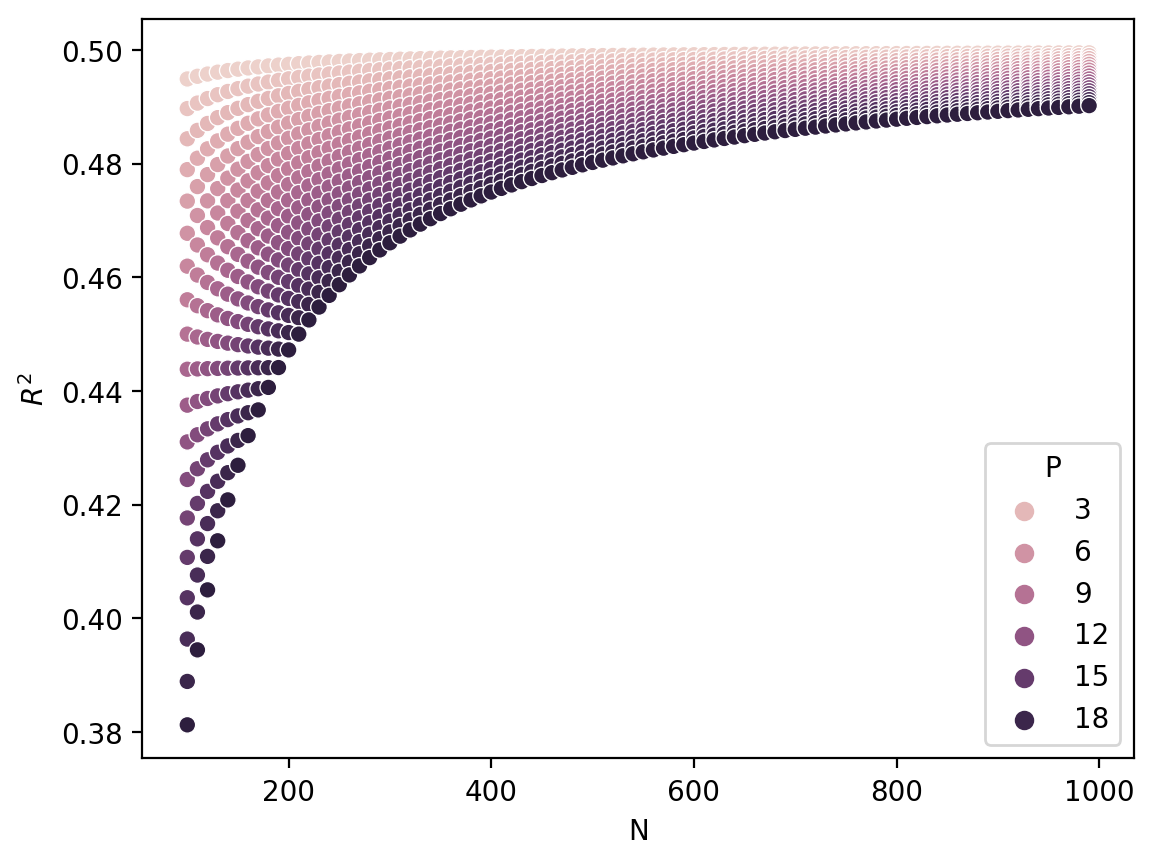

In [35]:
sns.scatterplot(data = df_adj, x = "N", y = "r2_adj", hue = "P")
plt.ylabel("$R^2$")

#### Extracting adjusted $R^2$ from `statsmodels`

- We can access this value using `model.rsquared_adj`.  
- Note that it *can* be negative in some cases!

In [36]:
mod_housing = smf.ols(data = df_housing,
                     formula = "median_house_value ~ housing_median_age + median_income").fit()
print(mod_housing.rsquared)
print(mod_housing.rsquared_adj)

0.5091195899765238
0.5090720171306622


### Stepwise selection in practice

Let's consider the case of **forward stepwise selection**, focusing on just these two variables predicting `median_house_value`.

#### Step 1: Null model

The **null model** can be fit by simply adding `1` as a predictor, i.e., an `Intercept`-only model.

In [37]:
mod_null = smf.ols(data = df_housing, formula = "median_house_value ~ 1").fit()
mod_null.rsquared_adj

4.9960036108132044e-15

#### Step 2: univariate models

Now, we fit a model for each of our $p$ predictors (`age` and `income`).

**Which parameter yields the biggest improvement in model fit?**

In [38]:
mod_age = smf.ols(data = df_housing, formula = "median_house_value ~ housing_median_age").fit()
mod_income = smf.ols(data = df_housing, formula = "median_house_value ~ median_income").fit()

In [39]:
print(mod_age.rsquared_adj)
print(mod_income.rsquared_adj)

0.011108391530172068
0.4734219780700054


#### Step 3: Adding more parameters

- In step 2, we decided that `median_income` was the best parameter for the *univariate* model. 
- Now we add `housing_median_age`.

In [40]:
mod_both = smf.ols(data = df_housing,
                   formula = "median_house_value ~ housing_median_age + median_income").fit()
mod_both.rsquared_adj

0.5090720171306622

#### Interpreting our results

- The model with *both* predictors explains about $51\%$ of the variance.  
- The model with `age` explains about $1\%$ of the variance. 
- The model with `income` explains about $47\%$ of the variance.

If we had to pick *just one* variable, we should go with `income`!

In [41]:
print("Both parameters: {x}.".format(x = round(mod_both.rsquared_adj, 2)))
print("Age: {x}.".format(x = round(mod_age.rsquared_adj, 2)))
print("Income: {x}.".format(x = round(mod_income.rsquared_adj, 2)))

Both parameters: 0.51.
Age: 0.01.
Income: 0.47.


### Conclusion

- **Multiple regression** allows us to:
   - Identify independent effects of our predictors.  
   - Build better, more predictive models.  
- We can also test for **interactions** between our predictors.  
- There are *many* techniques for identifying which predictors are most "important".
   - Includes *forward* and *backward* stepwise selection.